# Michigan QCEW (BEA-adjusted) — Moody vs BLS Forecast Comparison

Run `scripts/apply_bea_share_and_extend.py` first.

In [1]:

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

def find_repo_root(markers=("data", "scripts")) -> Path:
    here = Path.cwd()
    for p in (here, *here.parents):
        if all((p / m).exists() for m in markers):
            return p
    return here

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Working dir ->", Path.cwd())

DATA_INTERIM = REPO_ROOT / "data" / "interim"
DATA_PROCESSED = REPO_ROOT / "data" / "processed"
FIG_DIR = REPO_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

SEG_BASE = DATA_INTERIM / "mi_qcew_segment_employment_timeseries_bea.csv"
STG_BASE = DATA_INTERIM / "mi_qcew_stage_employment_timeseries_bea.csv"
SEG_CMP  = DATA_PROCESSED / "mi_qcew_segment_employment_timeseries_bea_extended_compare.csv"
STG_CMP  = DATA_PROCESSED / "mi_qcew_stage_employment_timeseries_bea_extended_compare.csv"

for p in [SEG_BASE, STG_BASE, SEG_CMP, STG_CMP]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required input: {p}. Run scripts/apply_bea_share_and_extend.py first.")

seg_base = pd.read_csv(SEG_BASE)
stg_base = pd.read_csv(STG_BASE)
seg_cmp  = pd.read_csv(SEG_CMP)
stg_cmp  = pd.read_csv(STG_CMP)

for df in (seg_base, stg_base, seg_cmp, stg_cmp):
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df.dropna(subset=["year"], inplace=True)
    df["year"] = df["year"].astype(int)

YR_MIN, YR_MAX = 2001, 2034


Working dir -> c:\Users\vasilauskas\GitHub\EV-Transition


In [2]:

def one_point_per_year(df, keys, value_col="employment_qcew", how="sum"):
    df = df.copy()
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["year"]).copy()
    df["year"] = df["year"].astype(int)
    agg = df.groupby(keys + ["year"], as_index=False)[value_col]
    df2 = (agg.sum() if how == "sum" else agg.mean()).sort_values("year")
    return df2

def _forecast_start_year(df):
    df2 = df[(df.get("value_type")=="Forecast") & df.get("year").notna()]
    return int(df2["year"].min()) if not df2.empty else None


In [3]:

def plot_stage(stage_name: str):
    base = one_point_per_year(stg_base[stg_base["stage"].astype(str).eq(stage_name)], ["stage"])
    cmp_ = stg_cmp[stg_cmp["stage"].astype(str).eq(stage_name)]
    moody = one_point_per_year(cmp_[(cmp_["value_type"]=="Forecast") & (cmp_["forecast_source"]=="Moody")], ["stage"]) if not cmp_.empty else pd.DataFrame()
    bls   = one_point_per_year(cmp_[(cmp_["value_type"]=="Forecast") & (cmp_["forecast_source"]=="BLS")],   ["stage"]) if not cmp_.empty else pd.DataFrame()

    fig, ax = plt.subplots(figsize=(12,6))
    if not base.empty:
        ax.plot(base["year"], base["employment_qcew"], label="QCEW (historical, BEA-adjusted)", linewidth=2)
    if not moody.empty:
        ax.plot(moody["year"], moody["employment_qcew"], label="Moody forecast", linestyle="--", linewidth=2)
    if not bls.empty:
        ax.plot(bls["year"], bls["employment_qcew"], label="BLS forecast", linestyle=":", linewidth=2)

    fstart = _forecast_start_year(cmp_)
    if fstart is not None and fstart <= YR_MAX:
        ax.axvspan(max(fstart, YR_MIN), YR_MAX, alpha=0.12, zorder=0)
        from matplotlib.patches import Patch
        patch = Patch(alpha=0.12, label="Forecast window")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(patch); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    ax.set_xlim(YR_MIN, YR_MAX)
    ax.set_xlabel("Year"); ax.set_ylabel("Employment (QCEW, BEA-adjusted)")
    ax.set_title(f"Michigan QCEW (BEA-adjusted) — {stage_name} (2001–2034)")
    fig.tight_layout()
    out = FIG_DIR / f"mi_qcew_bea_stage_{stage_name.lower()}_compare_2001_2034.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
    plt.show(); plt.close(fig)


In [4]:

def plot_segment(seg_id: int, seg_label: str):
    base = one_point_per_year(seg_base[seg_base["segment_id"].eq(seg_id)], ["segment_id"])
    cmp_ = seg_cmp[seg_cmp["segment_id"].eq(seg_id)]
    moody = one_point_per_year(cmp_[(cmp_["value_type"]=="Forecast") & (cmp_["forecast_source"]=="Moody")], ["segment_id"]) if not cmp_.empty else pd.DataFrame()
    bls   = one_point_per_year(cmp_[(cmp_["value_type"]=="Forecast") & (cmp_["forecast_source"]=="BLS")],   ["segment_id"]) if not cmp_.empty else pd.DataFrame()

    fig, ax = plt.subplots(figsize=(14,8))
    if not base.empty:
        ax.plot(base["year"], base["employment_qcew"], label="QCEW (historical, BEA-adjusted)", linewidth=2)
    if not moody.empty:
        ax.plot(moody["year"], moody["employment_qcew"], label="Moody forecast", linestyle="--", linewidth=2)
    if not bls.empty:
        ax.plot(bls["year"], bls["employment_qcew"], label="BLS forecast", linestyle=":", linewidth=2)

    fstart = _forecast_start_year(cmp_)
    if fstart is not None and fstart <= YR_MAX:
        ax.axvspan(max(fstart, YR_MIN), YR_MAX, alpha=0.12, zorder=0)
        from matplotlib.patches import Patch
        patch = Patch(alpha=0.12, label="Forecast window")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(patch); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    ax.set_xlim(YR_MIN, YR_MAX)
    ax.set_xlabel("Year"); ax.set_ylabel("Employment (QCEW, BEA-adjusted)")
    ax.set_title(f"Michigan QCEW (BEA-adjusted) — {seg_label} (2001–2034)")
    fig.tight_layout()
    out = FIG_DIR / f"mi_qcew_bea_segment_{seg_id}_compare_2001_2034.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
    plt.show(); plt.close(fig)


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_stage_downstream_compare_2001_2034.png


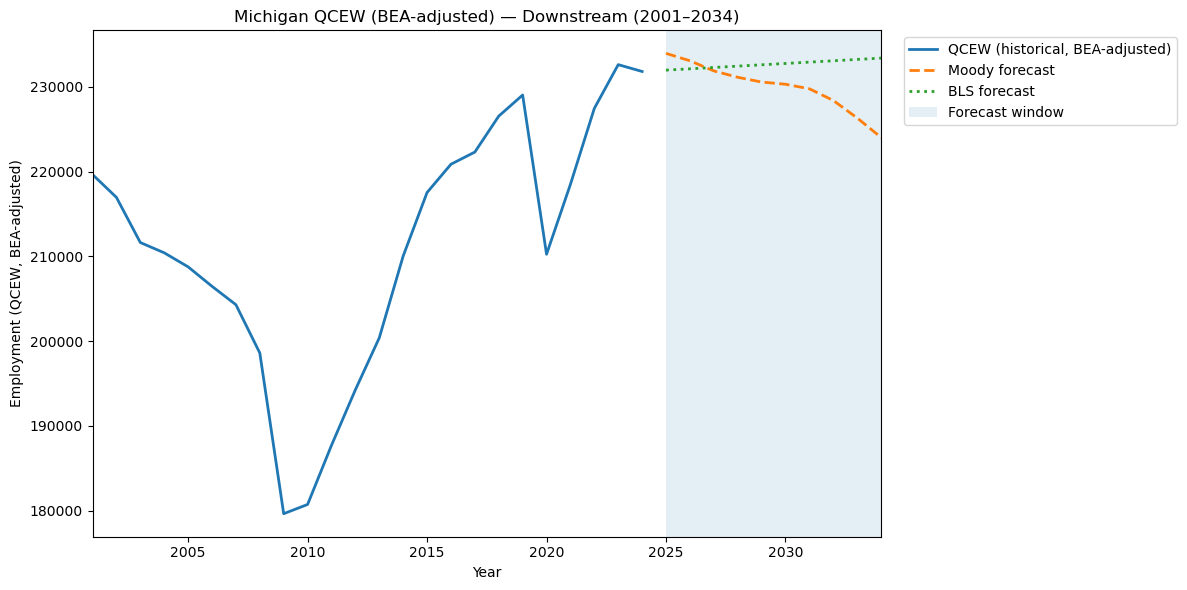

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_stage_oem_compare_2001_2034.png


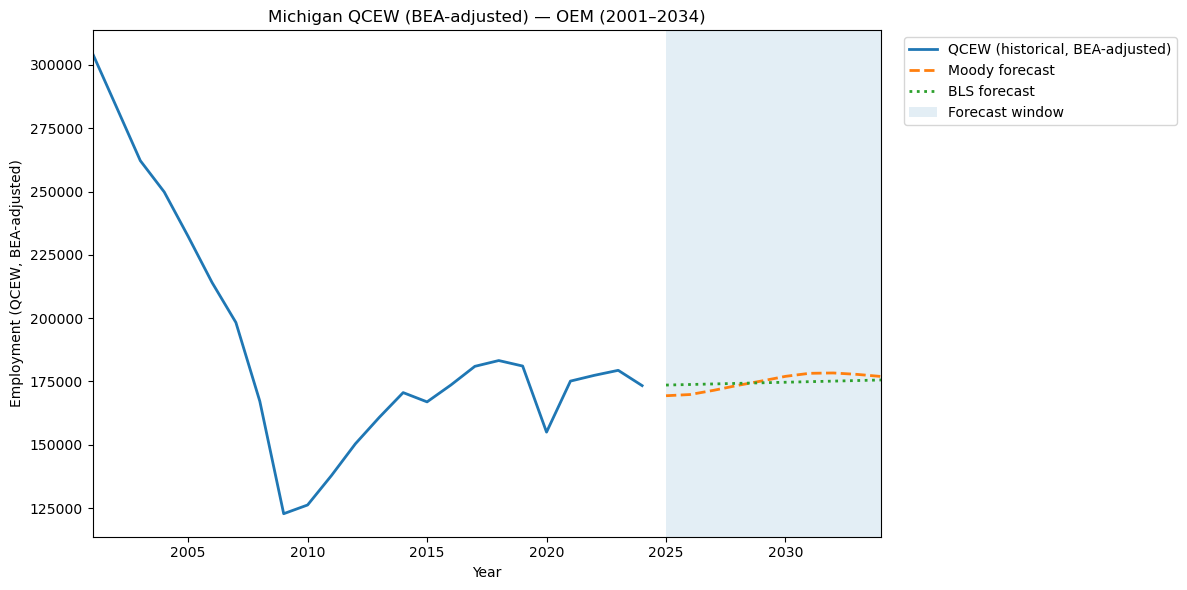

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_stage_upstream_compare_2001_2034.png


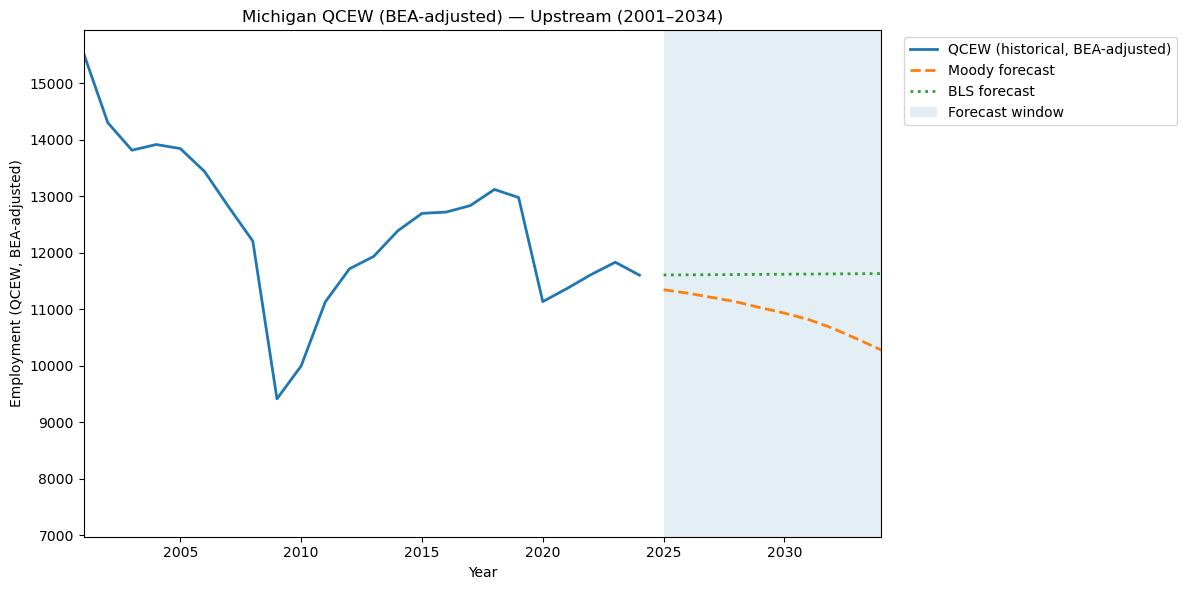

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_1_compare_2001_2034.png


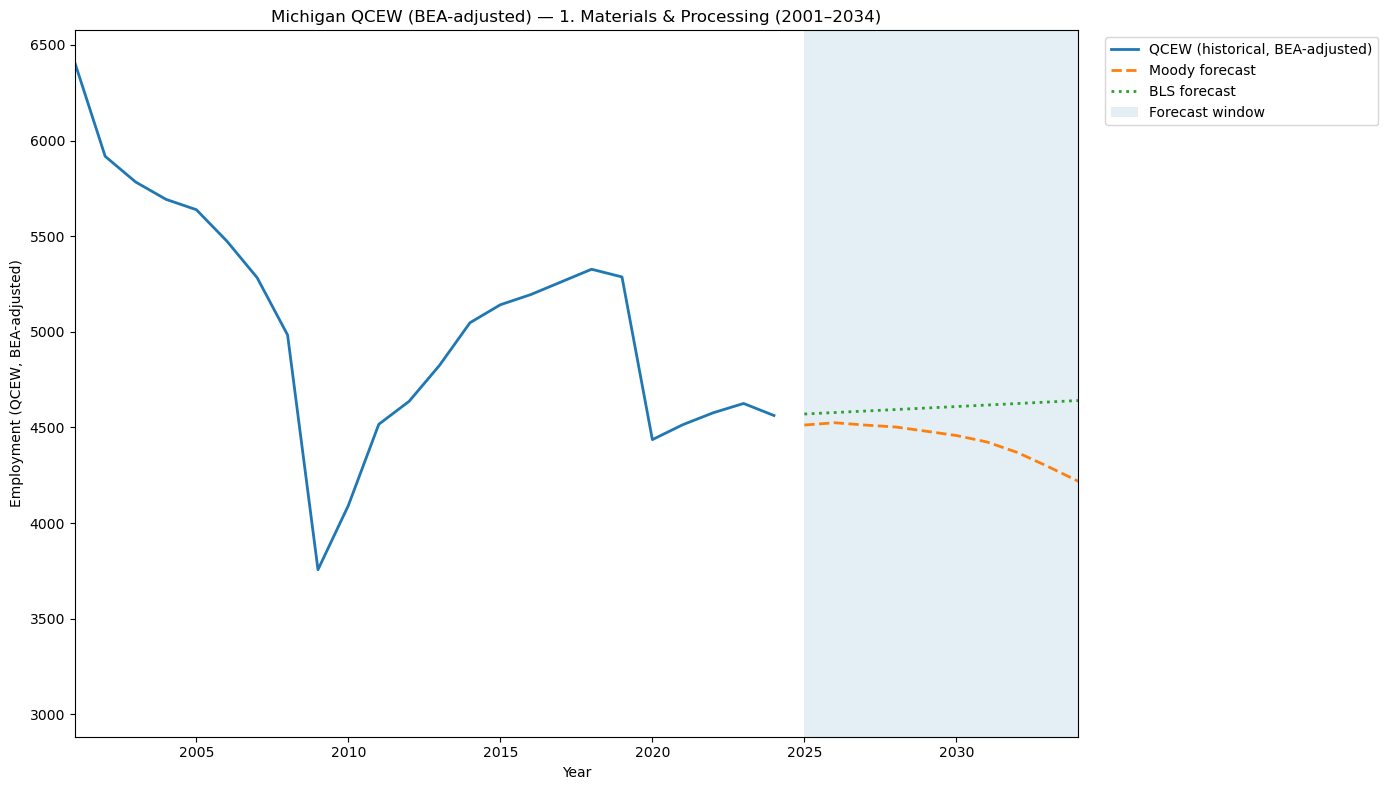

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_2_compare_2001_2034.png


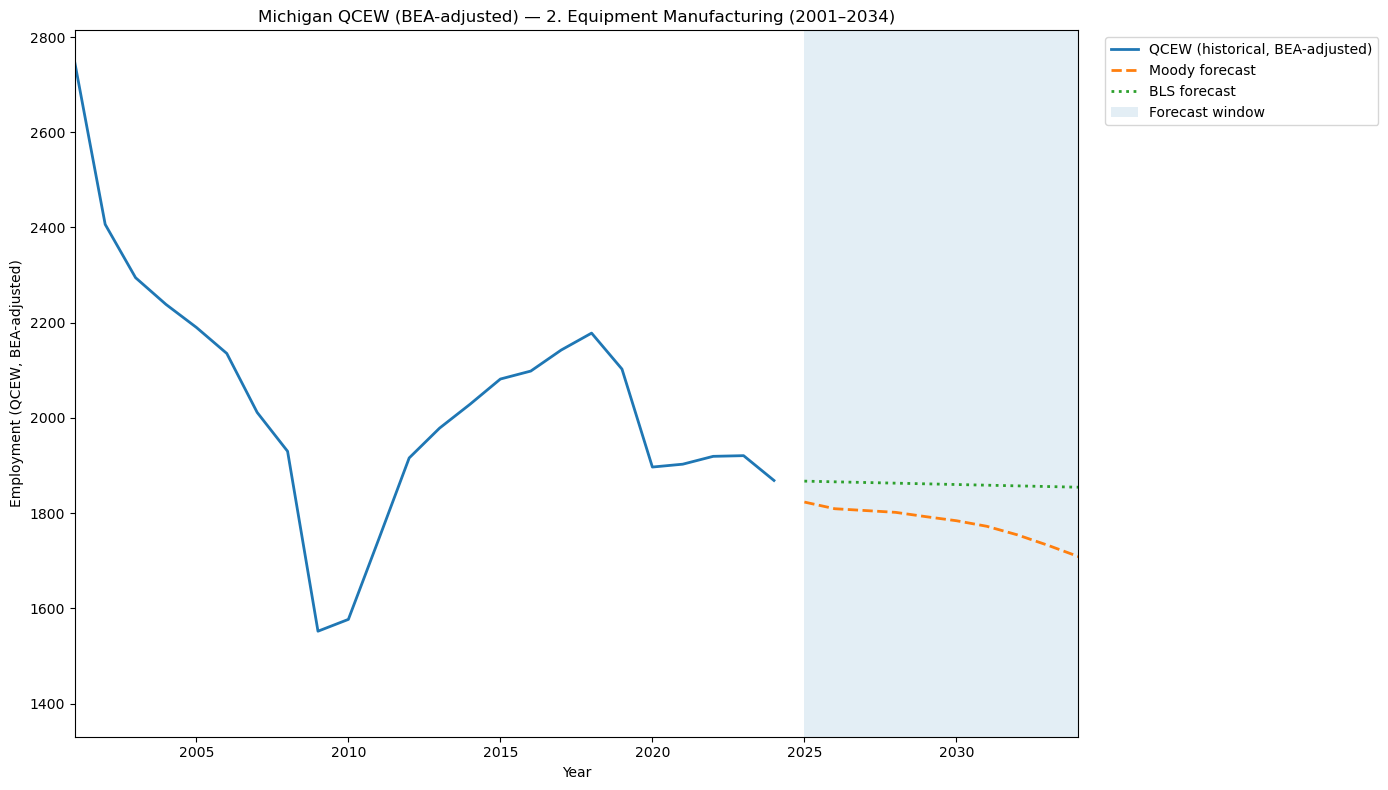

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_3_compare_2001_2034.png


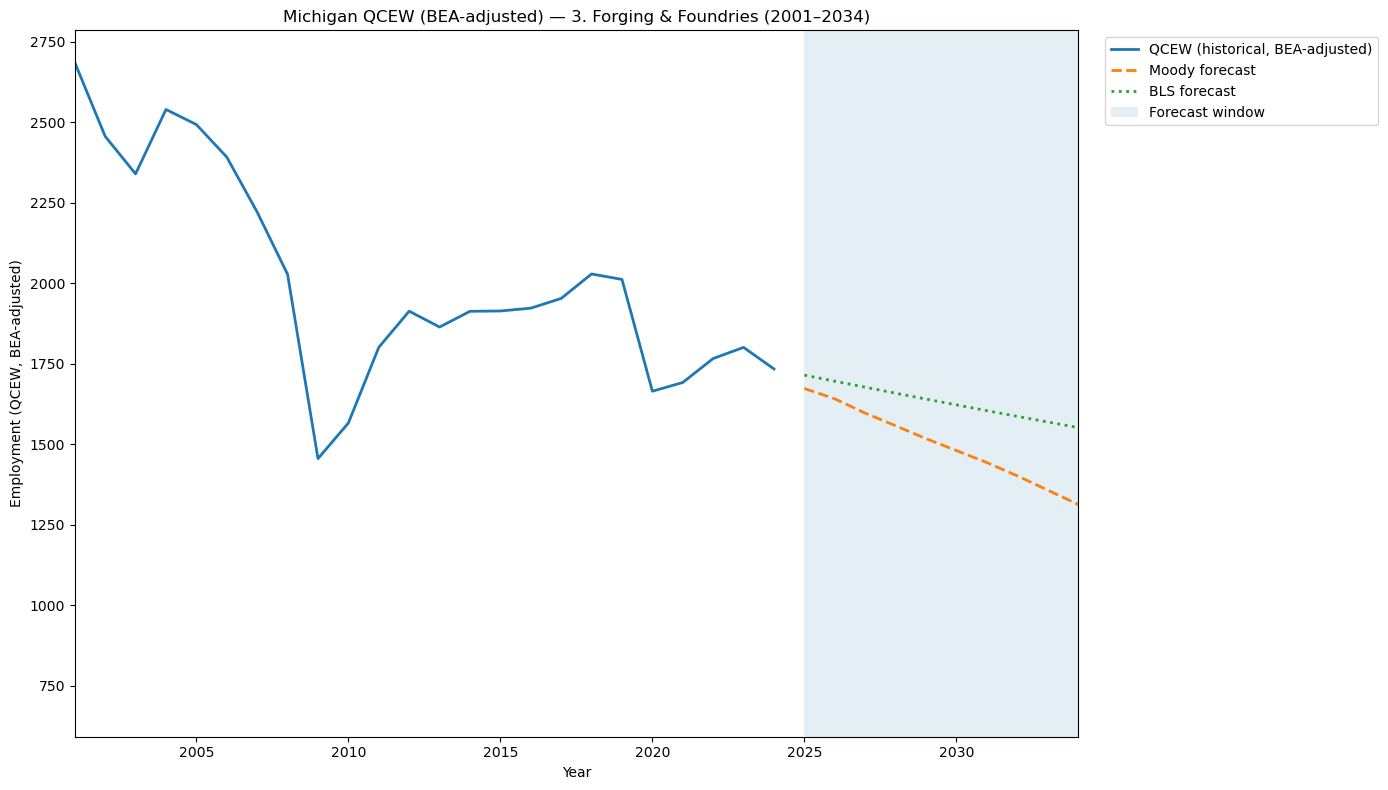

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_4_compare_2001_2034.png


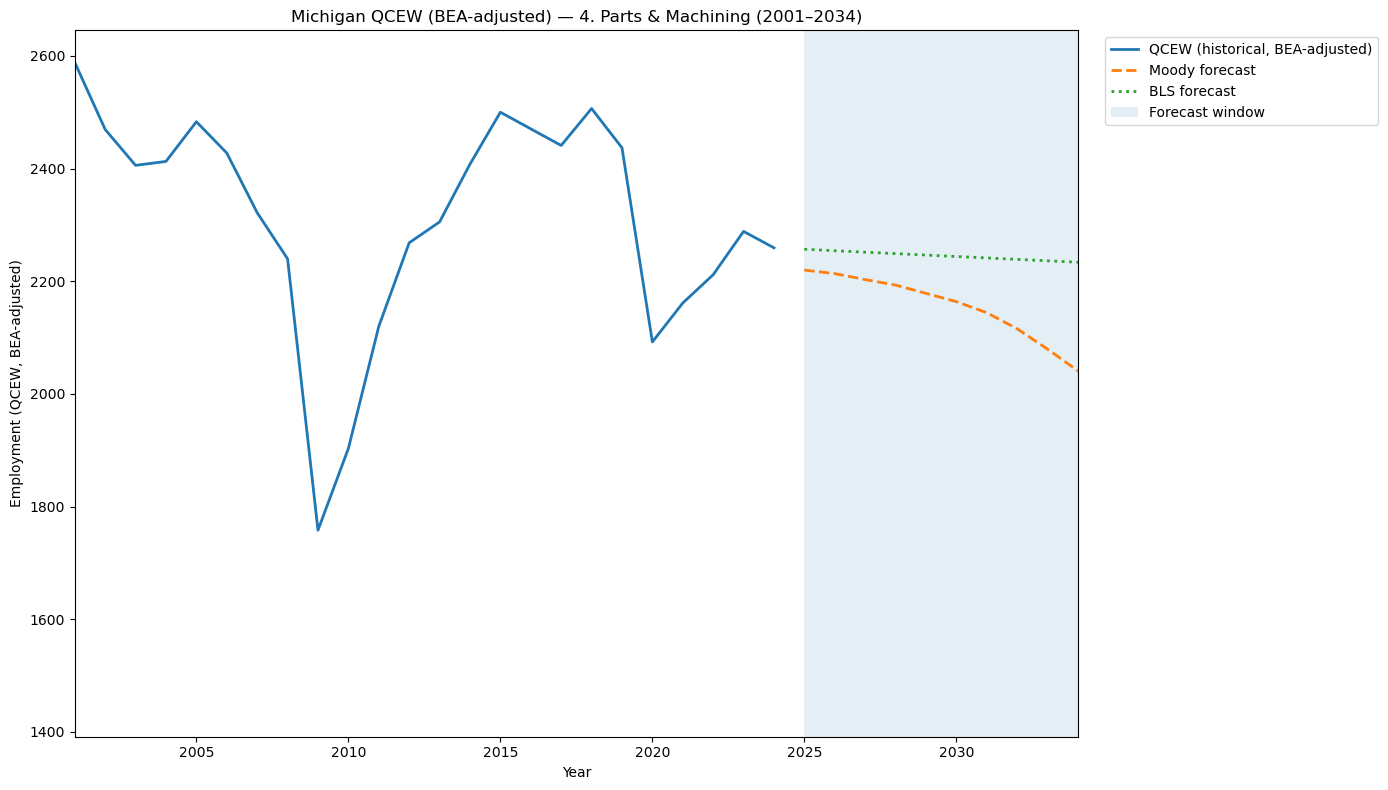

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_5_compare_2001_2034.png


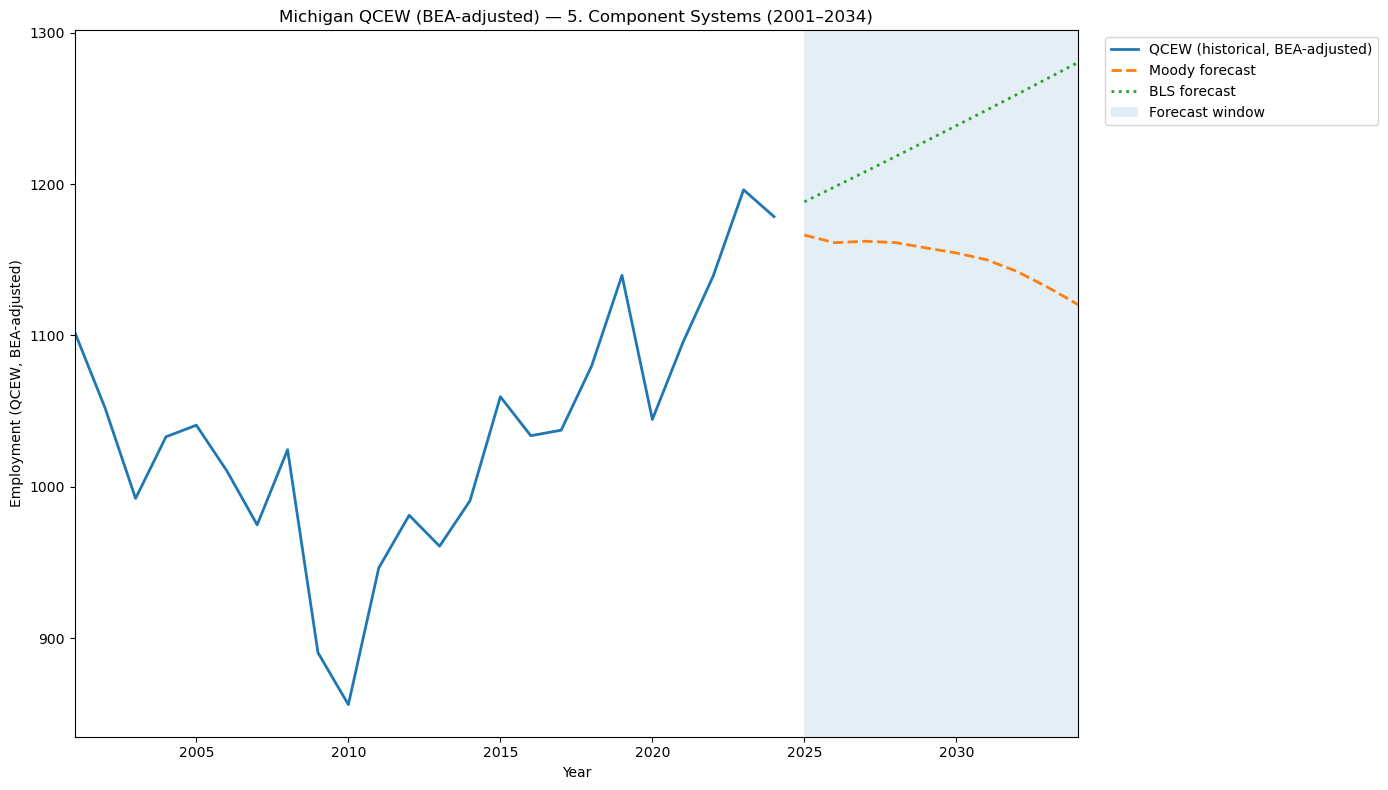

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_6_compare_2001_2034.png


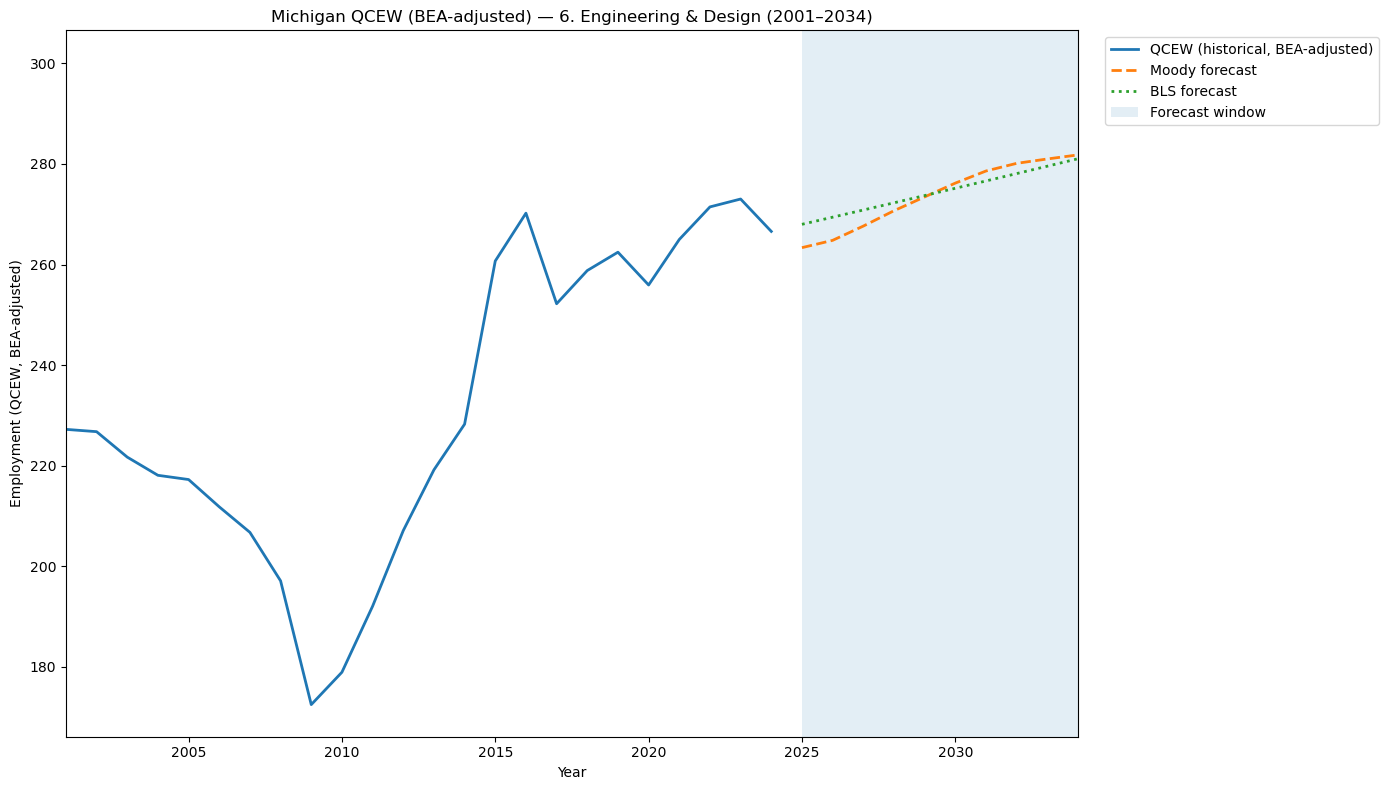

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_7_compare_2001_2034.png


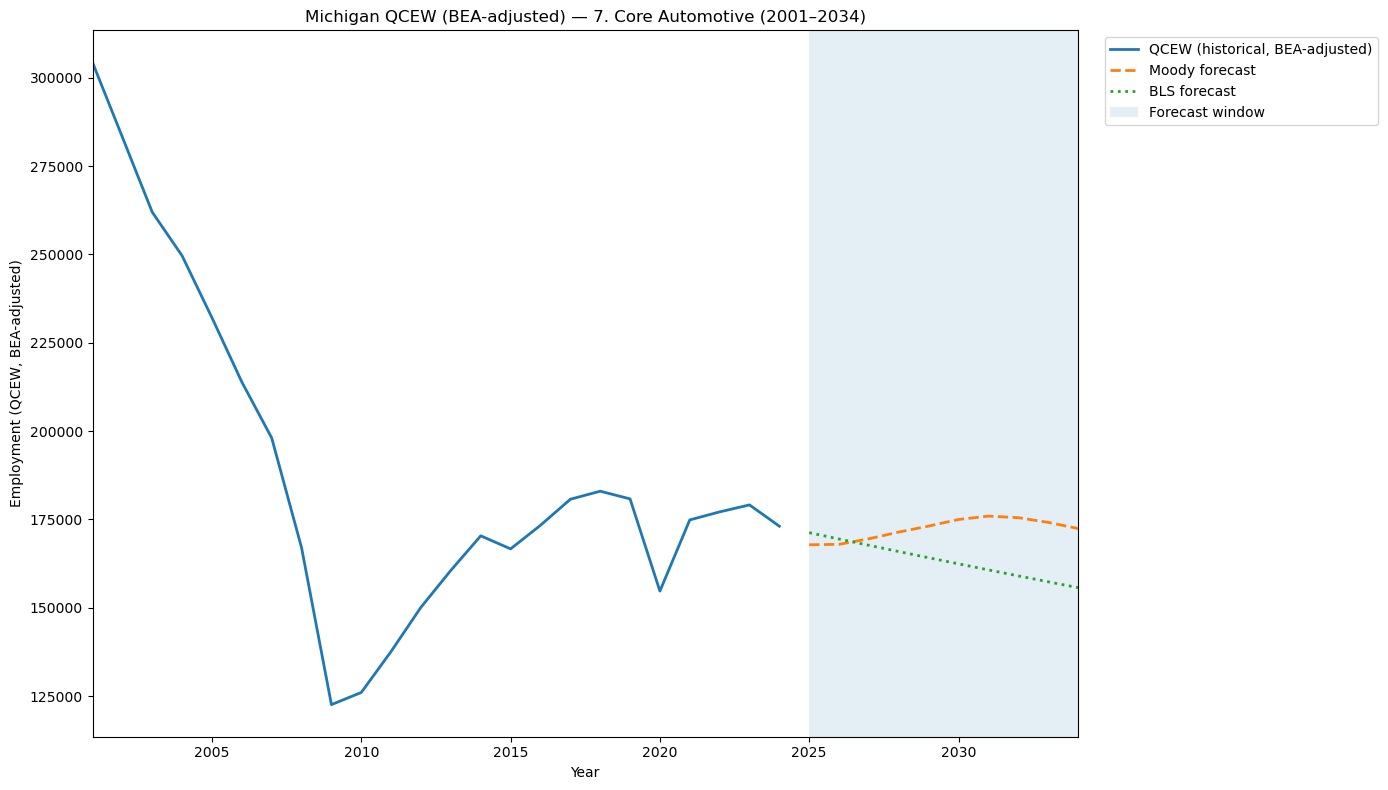

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_8_compare_2001_2034.png


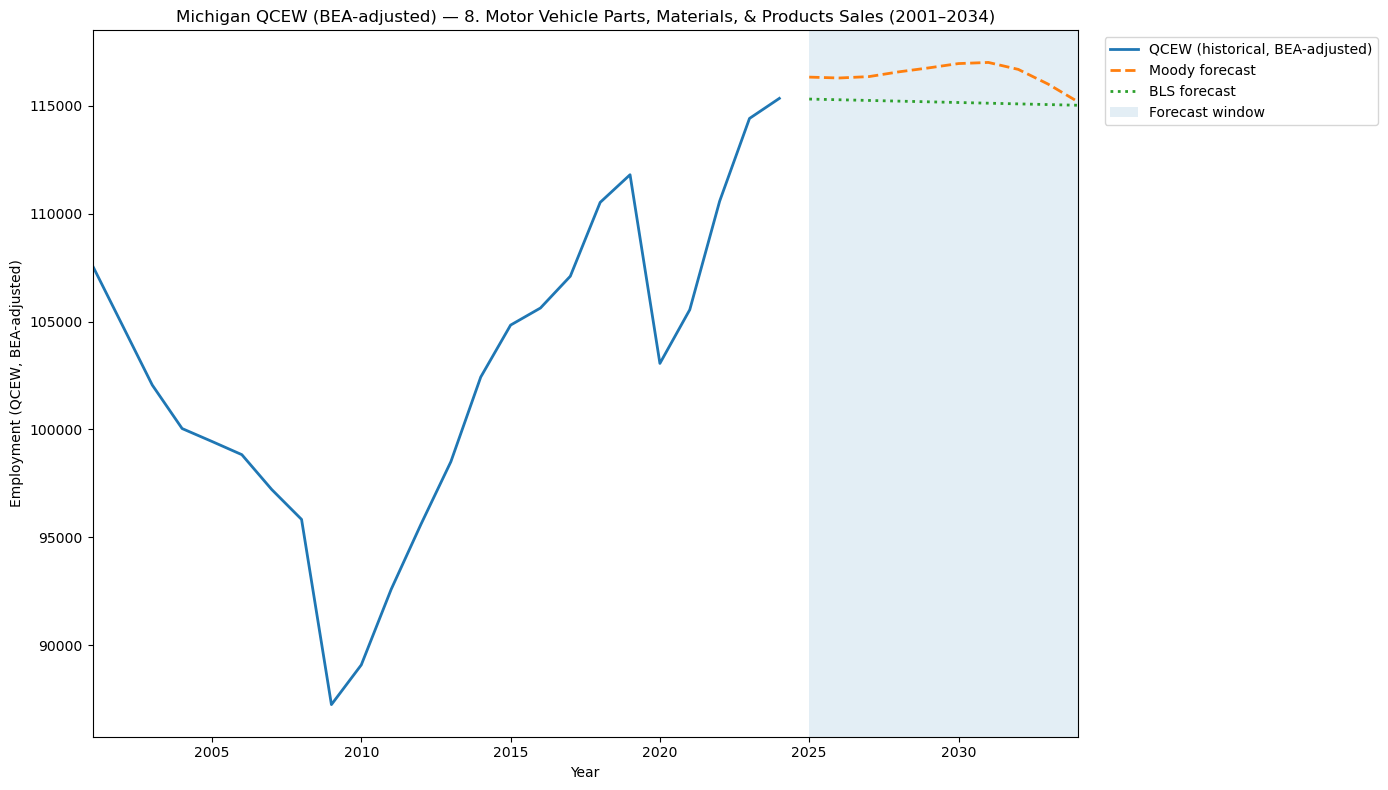

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_9_compare_2001_2034.png


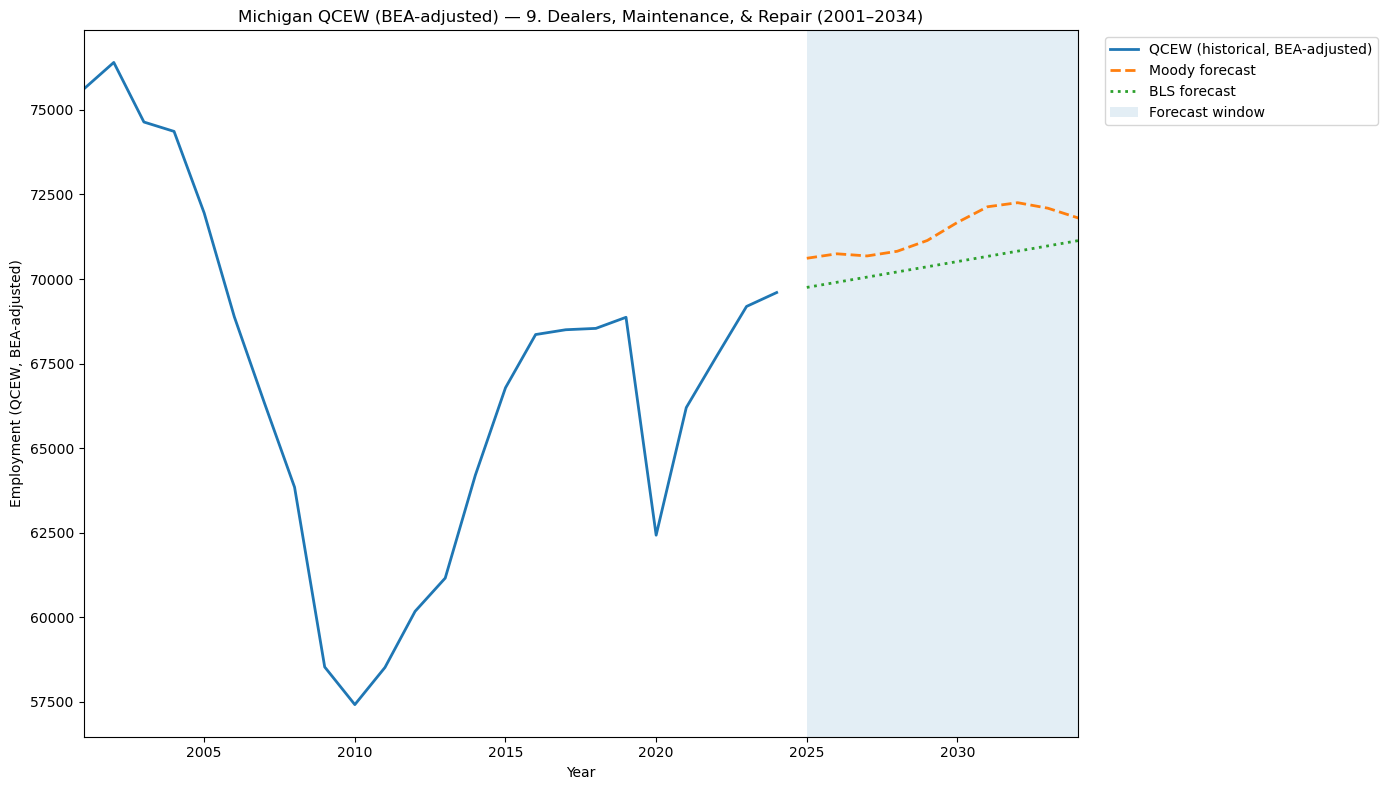

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_bea_segment_10_compare_2001_2034.png


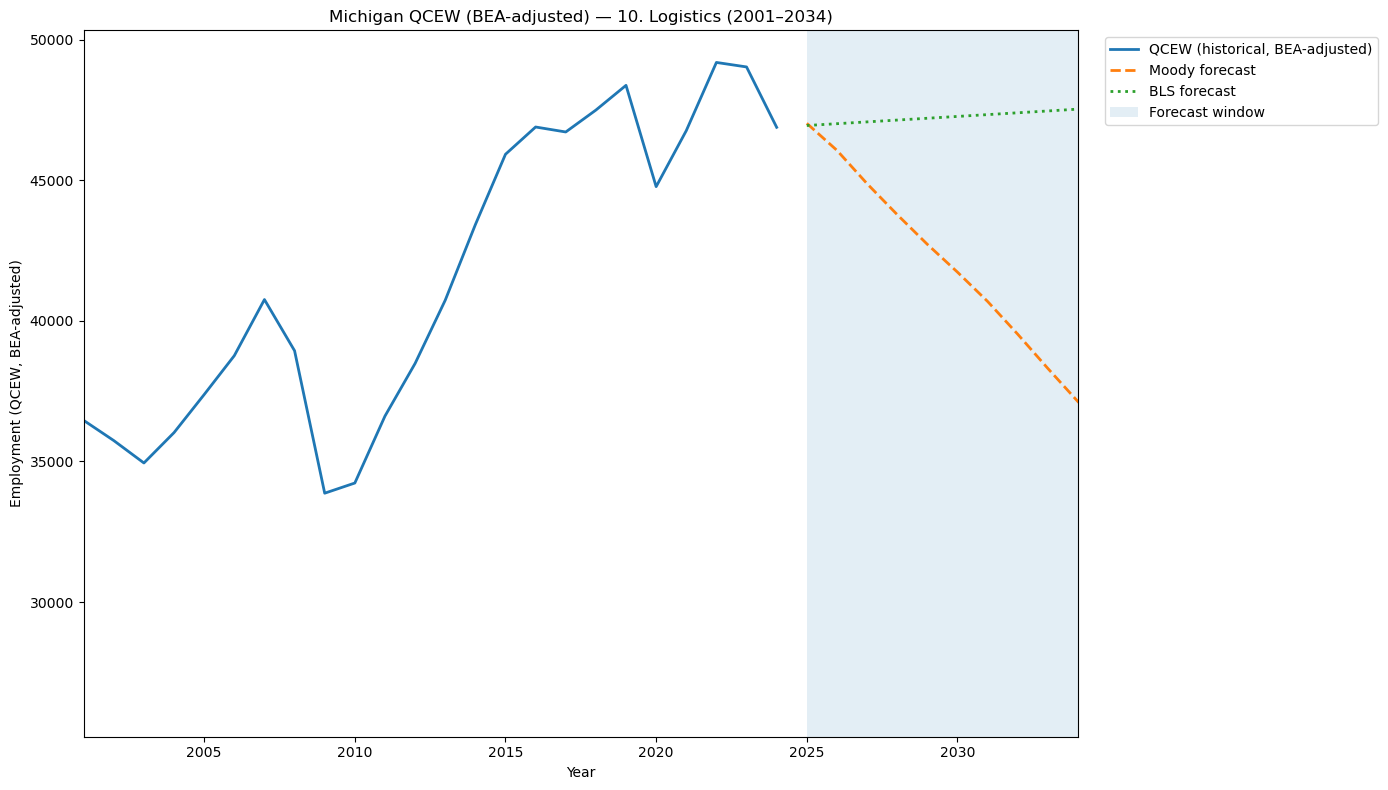

In [5]:

def batch_plot_stages():
    for st in sorted(stg_base["stage"].astype(str).unique()):
        plot_stage(st)

def batch_plot_segments():
    labels = seg_base.sort_values(["segment_id","year"]).groupby("segment_id")["segment_name"].first()
    for seg_id, seg_label in labels.items():
        plot_segment(int(seg_id), str(seg_label))

batch_plot_stages()
batch_plot_segments()
